## Study on Dataset Size requirements of the different models with random splitting

### Import dependancies

In [1]:
import os
import torch
import copy
from geom3d import train_models
from geom3d.train_models import Pymodel
from geom3d.train_models import read_config, load_data, train_val_test_split, model_setup
import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Inference test function to extract MAE, MSE from model checkpoints

In [2]:
def test_model(chkpt_path, config_dir):
    config = read_config(config_dir)
    np.random.seed(config["seed"])
    torch.cuda.manual_seed_all(config["seed"])
    torch.manual_seed(config["seed"])
    config["device"] = "cuda:0" if torch.cuda.is_available() else "cpu"

    print('checkpoint used:', chkpt_path)
    checkpoint = torch.load(chkpt_path)
    model, graph_pred_linear = model_setup(config)
    print("Model loaded: ", config["model_name"])

    # Pass the model and graph_pred_linear to the Pymodel constructor
    pymodel = Pymodel(model, graph_pred_linear, config)
    # Load the state dictionary
    pymodel.load_state_dict(state_dict=checkpoint['state_dict'])
    # Set the model to evaluation mode
    pymodel.eval()

    dataset = load_data(config)
    np.random.seed(config["seed"])
    torch.cuda.manual_seed_all(config["seed"])
    pymodel = pymodel.to(config["device"])

    config['smart_dataset_size'] = None

    train_loader, val_loader, test_loader = train_val_test_split(
        dataset, config=config, batch_size=config["batch_size"]
    )

    print("pymodel device", pymodel.device)
    print("Target: ", config["target_name"])

    # Get the y values from the dataset for setting plot axes
    y_values = [data.y for data in dataset]

    y_true = []
    y_pred = []
    for x in test_loader:
        with torch.no_grad():
            Y_pred = pymodel(x.to(config["device"]))
        y_true.append(x.y.to('cpu'))
        y_pred.append(Y_pred.to('cpu').detach())
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    print('Mean Absolute Error (MAE) on test_set:', mae)

    # calculate the mean squared error
    mse = mean_squared_error(y_true, y_pred)
    print('Mean Squared Error (MSE) on test_set:', mse)

    return mae, mse


### Automated process to retrieve errors for different dataset sizes on trained

In [3]:
import os
import pandas as pd

model_names = ['PaiNN', 'SchNet', 'DimeNet', 'DimeNetPlusPlus', 'SphereNet', 'Equiformer']
num_mols = [80000, 40000, 10000, 5000]
mse_data = {}
epoch_data = {} 
# Loop over model names
for model_name in model_names:
    mse_values = []
    epoch_values = []  # List to store epoch values
    # Loop over number of molecules
    for num_mol in num_mols:
        config_dir = f"/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/{model_name}_opt_combined_{num_mol}"
        # Find the checkpoint path
        for file in os.listdir(config_dir):
            if file.endswith(".ckpt"):
                chkpt_path = os.path.join(config_dir, file)
                # Extract epoch number from the file name
                epoch = int(file.split('epoch=')[1].split('-')[0])  # Extract the epoch number
                epoch_values.append(epoch)
                break  # Break after finding the first checkpoint file
        mae, mse = test_model(chkpt_path, config_dir)
        mse_values.append(mse)

    mse_data[model_name] = mse_values
    epoch_data[model_name] = epoch_values

# Create DataFrames
df = pd.DataFrame(mse_data, index=num_mols)
df_2 = pd.DataFrame(epoch_data, index=num_mols)

print("MSE DataFrame:")
print(df)
print("\nEpoch DataFrame:")
print(df_2)


    

config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/PaiNN_opt_combined_80000
checkpoint used: /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/PaiNN_opt_combined_80000/epoch=58-val_loss=0.47-other_metric=0.00.ckpt
Model loaded:  PaiNN
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/80000dataset_radius_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/datasplit_80000_random.npz
train_idx:  [47044 44295 74783 ... 77925 18116 14762]
valid_idx:  [39698 66692  7139 ... 52300 56176  3346]
test_idx:  [61260 28261 49228 ... 76820   860 15795]
set()
set()
Number of training samples: 64000
Number of validation samples: 8000
Number of test samples: 8000
pymodel device cuda:0
Target:  combined
Mean Absolute Error (MAE) on test_set: 0.39077955
Mean Squared Error (MSE) on test_set: 0.46585676
config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/PaiNN_opt_combined_40000
chec

/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support

Model loaded:  Equiformer
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/80000dataset_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/datasplit_80000_random.npz
train_idx:  [47044 44295 74783 ... 77925 18116 14762]
valid_idx:  [39698 66692  7139 ... 52300 56176  3346]
test_idx:  [61260 28261 49228 ... 76820   860 15795]
set()
set()
Number of training samples: 64000
Number of validation samples: 8000
Number of test samples: 8000
pymodel device cuda:0
Target:  combined
Mean Absolute Error (MAE) on test_set: 0.3220096
Mean Squared Error (MSE) on test_set: 0.35630462
config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/Equiformer_opt_combined_40000
checkpoint used: /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/Equiformer_opt_combined_40000/epoch=71-val_loss=0.48-other_metric=0.00.ckpt


/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Model loaded:  Equiformer
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/40000dataset_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/datasplit_40000_random.npz
train_idx:  [32823 16298 28505 ... 32713 21669 30702]
valid_idx:  [26770 19569 13636 ... 19212 28302 39316]
test_idx:  [27081 14908  9306 ... 38158   860 15795]
set()
set()
Number of training samples: 32000
Number of validation samples: 4000
Number of test samples: 4000
pymodel device cuda:0
Target:  combined
Mean Absolute Error (MAE) on test_set: 0.41213593
Mean Squared Error (MSE) on test_set: 0.5195018
config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/Equiformer_opt_combined_10000
checkpoint used: /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/Equiformer_opt_combined_10000/epoch=85-val_loss=0.69-other_metric=0.00.ckpt


/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Model loaded:  Equiformer
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/10000dataset_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/datasplit_10000_random.npz
train_idx:  [6252 4684 1731 ... 7427  608 6907]
valid_idx:  [ 399 7247 6406  882 3565 4285 1179 5448 4244 5218 3976 2130 5078  456
 5582 5175 1950 5372  689 8852 6525 9821 6488 6921 1953 7634 5636 7154
 8424 6610 2710 8730 3201 4349 4138 1884 8639 4485 2494 5947 3036 5777
 3603  845  542 3724 4187 3679 8899 7967 8485 6075 7340 8225 7246 9710
 8290 7137 2964 7559 2529 7284 5772 1048 7045 1960 2530 9048 7603 6524
  237 4917 6479 1133 6976 5901 9057 4259 8840 6965 9979  792 1985 5656
 8739 7935 6097 5907 7373 8128 2978 8861 9301 6721 7842 5524 8721 8431
 9008 8603 7174 3919 3138 9416 9933 5789 4073 3287 3229 1826 5548  593
 2725 4137  560 7406 8806 8386  243 7268 5435 4437 9684 8106  405 1442
  261 4406 7633 9533 1689 9866 1725 8994 4930 5962 2496 9014 6904 6106

/rds/general/user/cb1319/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


Model loaded:  Equiformer
/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/5000dataset_combined.pt
Loading dataset split indices from /rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/datasplit_5000_random.npz
train_idx:  [1501 2586 2653 ... 3715 4646  946]
valid_idx:  [1701 3293 2161 1136  987 2549  193 3057 3246 1394 2637  768 4702 3090
 3495 3215  285 4938  428 4448 2332 2717 2079 3389  722  951 4383 4366
 2262  989 3212 1759 4579  326 2608 1383 1724 1086 2523  341 3701  147
  688 3432 1107  848  966 4727 1492 3953 2203 2713  661 1002   62  284
 2224 4706 1879 3572 4857 1203 1990   24 4852 4102 4167  762  875 4742
  938 2687 3600 2394 4567 4980 4124 4564  385 3877 4370 4569  536 2291
 4665 3874  936 3737 4728 2360 3507  201 3208 1332 3016 3502 2708 4021
 1854 4469 2872 3030 1205 1645 3417 3476 2861 1792 3797 3368 3367 3533
 3449  603 3056 4531  126 3876 2935 3531 2730  827 1639  984 3281 4971
 2188 4612 2443  362 2349  345  814 3205 4160 4795 3325 4106 2116 1834
 

In [4]:
# Save the DataFrames to csv files at the current directory
df.to_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/mse_data.csv')
df_2.to_csv('/rds/general/user/cb1319/home/GEOM3D/Geom3D/datasize_study/epoch_data.csv')

### Plotting the difference in error between different dataset sizes for the different models

In [4]:
%matplotlib inline

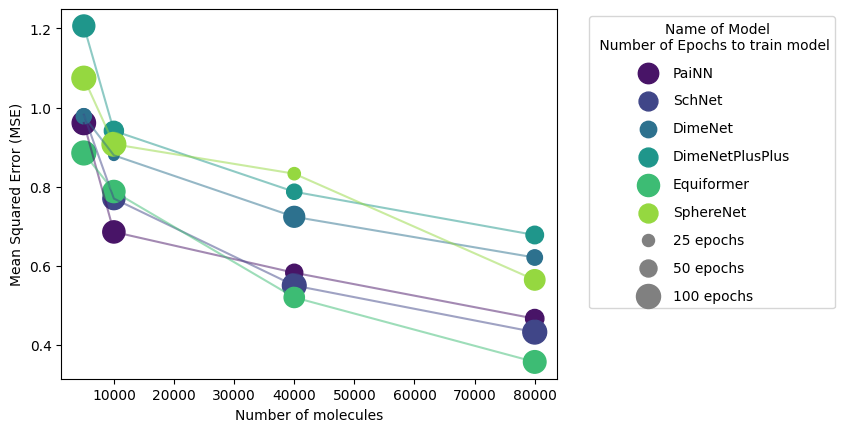

Improvement in MSE from 40000 to 80000 molecules:
PaiNN: -24.93%
SchNet: -27.29%
DimeNet: -16.59%
DimeNetPlusPlus: -16.15%
SphereNet: -47.64%
Equiformer: -45.80%
Average improvement in MSE from 40000 to 80000 molecules:
-29.74%


In [5]:
# plot only PaiNN and SchNet

import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots()

# Set labels
ax.set_xlabel('Number of molecules')
ax.set_ylabel('Mean Squared Error (MSE)')

# Set color palette to one that uses red to yellow
colors = sns.color_palette('viridis', n_colors=max(len(df.columns) * 3, 2))  # Ensure at least 2 colors

# Iterate over the model data only for PaiNN and SchNet
for i, (colname, coldata) in enumerate(df[['PaiNN', 'SchNet', 'DimeNet', 'DimeNetPlusPlus', 'Equiformer', 'SphereNet']].items()):
    epochs = df_2[colname]  # Get epochs data for this model
    
    # Adjust marker size based on the number of epochs
    marker_size = epochs * 3  # You can adjust the scaling factor as needed
    
    # Plot with adjusted marker size and color
    ax.scatter(coldata.index, coldata, s=marker_size, color=colors[i * 3 % len(colors)], label=f'{colname}')
    
    # Add thin line connecting the dots
    ax.plot(coldata.index, coldata, color=colors[i * 3 % len(colors)], linestyle='-', alpha=0.5)

# Add dummy scatter plots with different marker sizes to legend
for size in [25, 50, 100]:
    ax.scatter([], [], s=size*3, label=f'{size} epochs', color='grey', alpha=1)

# Display legend outside the graph
plt.legend(scatterpoints=1, labelspacing=1, title='                Name of Model \n Number of Epochs to train model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# calculate on average how much all models have improved from 40000 to 80000 molecules
improvement = {}
for model_name in model_names:
    improvement[model_name] = (mse_data[model_name][0] - mse_data[model_name][1]) / mse_data[model_name][0] * 100

print("Improvement in MSE from 40000 to 80000 molecules:")
for model_name, value in improvement.items():
    print(f"{model_name}: {value:.2f}%")

print("Average improvement in MSE from 40000 to 80000 molecules:")
average_improvement = sum(improvement.values()) / len(improvement)
print(f"{average_improvement:.2f}%")
